# $E_{peak} - E_{iso}$ relation with errors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Correlation between $E_{peak}$ (spectral peak energy from $\nu F_\nu - \nu$ diagram) and $E_{iso}$ (equivalent isotropic energy).
Since the scatter plot is logarithmic, the correlation will be a power-law:
$$E_{peak} = m \cdot E_{iso}^q$$
where $m$ is the normalization factor and $q$ the slope.

The correlation can also be done between $E_{peak}$ and $E_\gamma$, which is the collimation-corrected energy, where $E_\gamma = E_{iso} \cdot (1 - cos\theta_{jet})$. Where $\theta_{jet}$ is derived from the jet break time $T_{\text{break}}$, which creates a broken power-law in the flux-time plot when $\theta_j \sim \theta_\Gamma \sim 1/\Gamma$.

In [2]:
df = pd.read_csv('table.csv') # read the data from Ghirlanda et al. 2008

In the readed data we can find the peak spectral energy $E_{peak}$ and the isotropic equivalent energy $E_{iso}$. Let's procede to create a scatter plot of both. First, we need to transform the `string` values fo $E_{\text{iso}}$ to `float`, and convert $\text{keV}$ to $\text{ergs} = \text{grcm}^2\text{s}^{-2}$ for $E_{\text{peak}}$.

In [3]:
def get_float(col):
    return np.array([float(base) * 10**float(exponent) for val in col for base, exponent in [str(val).split('e')]])

We can plot the data and then impose a `plt.loglog` scaling.

Text(0, 0.5, '$log(E_{\\text{peak}})$')

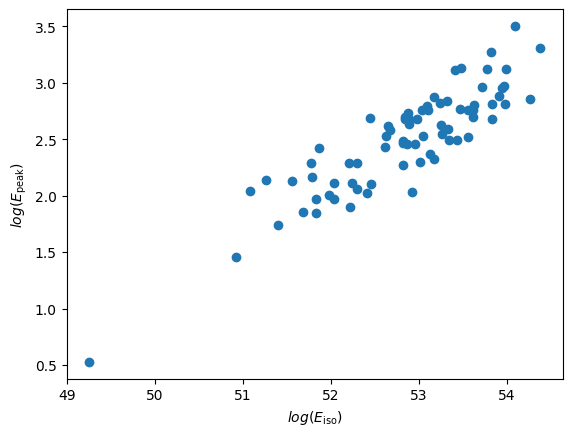

In [9]:
Epeak = np.log10(df['Epeak']) # keV
# logEpeak_err = df['Epeak_err'] / (df['Epeak'] * np.log(10)) # correct error propagation

Eiso = np.log10(get_float(df['Eiso'])) # ergs
# logEiso_err = df['Eiso_err'] / (df['Eiso'] * np.log(10))

plt.figure()
plt.scatter(Eiso, Epeak)
#plt.errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='.') # everything in ergs

plt.xlabel(r'$log(E_{\text{iso}})$')
plt.ylabel(r'$log(E_{\text{peak}})$')

Or we can try to produce logarithmisiced lists of the data and plot those. Error propagation with logarithmic plots! In order to plot the error uncertainty of the magnitudes in both axis, we need to use the correct error propagation equation:
$$\sigma_{\text{log}} = \sigma_{\text{original}} / (\text{value} \cdot ln(10))$$

Next we'll try to find a fit for these GRB properties ($E_{\text{peak}}$ - $E_{\text{iso}}$). As explained above, this will be a power-law: $E_{\text{peak}} = m \cdot E_{\text{iso}}^q$. I will use a goodness of fit function (using the $\chi^2$ method and a parameter space $(m,q)$ to find the 'best fit'.

For the goodness of fit function we will use the $\chi^2$ method, following:
$$\chi^2 = \sum_{i=1} ^N \frac{\left(O_i - E_i \right)^2}{E_i^2}$$,
where $E_i$ and $O_i$ are the expected and observed values respectively.

In [ ]:
def GoFNoErrors(m,q,x=Eiso, y=Epeak): #TODO: for the moment, this GoF function does not take the errors into account
    """
    Goodness of fit following the chi-squared formula
    :param m: normalization factor of power-law
    :param q: slope of power-law
    :param x: x-values
    :param y: y-values
    :return: sum of chi-squared error
    """

    model = m*x**q
    chi_squared = []
    for i in range(len(x)):
        val = ((y[i] - model[i])**2)/model[i]
        chi_squared.append(val)

    return np.sum(chi_squared)

In [ ]:
def GoF(m, q, x=Eiso, y=Epeak, x_err=Eiso_err, y_err=Epeak_err):
    """
    Goodness of fit following the chi-squared formula with error propagation
    :param m: normalization factor of power-law
    :param q: slope of power-law
    :param x: x-values
    :param y: y-values
    :param x_err: uncertainties in x-values
    :param y_err: uncertainties in y-values
    :return: chi-squared value
    """

    model = m * x**q

    # Calculate total uncertainty using error propagation
    total_variance = np.zeros_like(x)
    total_variance += y_err**2 # add yerr contribution

    # add xerr contribution
    model_derivative = m*q*x**(q-1)
    total_variance += (model_derivative*x_err)**2

    # Calculate chi-squared with proper error weighting
    chi_squared = np.sum(((y - model)**2) / total_variance)

    return chi_squared

In [ ]:
m = np.linspace(10**(-22), 10**(-25), 100) #from the previous scatter plots (passing the keV data to the GoF function), we can infer that the y-axis cut is arround 10 for x=10**9, meaning that the normalization factor should be around 10**-22 and 10**-25
q = np.linspace(0.4, 0.6, 100) # if this is the slope of the power-law, it must be positive

G = np.zeros([len(m), len(q)])
for i in range(len(m)):
    for j in range(len(q)):
        G[i][j] = GoF(m[i], q[j], x=Eiso, y=df['Epeak'])

fig = plt.figure()
plt.contourf(m,q,np.log10(G))
plt.colorbar(label=r'$log_{10}(\text{GoF})$')
plt.xlabel(r'Parameter $m$')
plt.ylabel(r'Parameter $q$')

Now we extract the best fit parameters, i.e. where the error squares are the least, and plot the fit over the scatter.

In [ ]:
bestfit = np.argmin(G)
m_index, q_index = np.unravel_index(bestfit, G.shape)
m_fit, q_fit = m[m_index], q[q_index]
#m_fit, q_fit = 10**(-24), 0.5
plt.figure()
plt.errorbar(Eiso, df['Epeak'], xerr=Eiso_err, yerr=df['Epeak_err'], fmt='.')
plt.plot(Eiso, m_fit*(Eiso**q_fit), color='r', label=f'$m={m_fit}$, $q={q_fit}$')

plt.loglog()
plt.legend(loc='upper left')
plt.xlabel('Eiso')
plt.ylabel('Epeak')